In [1]:
import pandas as pd
from pathlib import Path

# Ruta local a los históricos recientes
DATA_PATH = Path("D:/trading/data/historic")

# Cargar todos los archivos parquet en un diccionario por símbolo
historicos = {
    archivo.stem: pd.read_parquet(archivo)
    for archivo in DATA_PATH.glob("*.parquet")
}

print(f"Se cargaron {len(historicos)} símbolos.")
# Mostrar un preview del primero
historicos[list(historicos.keys())[0]].head()



Se cargaron 429 símbolos.


,open,high,low,close,volume,fecha
0,18.44063,18.454940,18.14735,18.30472,2015217,2005-07-22
1,18.26180,18.454940,18.22604,18.31187,1645586,2005-07-25
2,18.31187,18.733910,18.31187,18.58369,2810679,2005-07-26
3,18.63376,19.048641,18.59800,18.88412,3298581,2005-07-27
4,18.88412,18.941350,18.77682,18.89843,1375492,2005-07-28


In [2]:
import numpy as np
import pandas as pd

resumen = []

for simbolo, df in historicos.items():
    if len(df) < 60:
        continue  # ignorar si hay pocos datos

    df_ultimos = df.sort_values("fecha").tail(60)
    precios = df_ultimos["close"].reset_index(drop=True)
    volumenes = df_ultimos["volume"].reset_index(drop=True)

    # Percentiles precio y volumen
    p25, p75 = np.percentile(precios, [25, 75])
    v25, v75 = np.percentile(volumenes, [25, 75])

    # Canal porcentual
    canal_pct = (p75 - p25) / ((p75 + p25) / 2) * 100

    # Últimos valores
    close_ult = precios.iloc[-1]
    vol_ult = volumenes.iloc[-1]
    vol_media_60 = volumenes.mean()

    # Scores de volumen y precio actual
    score_vol = 0 if vol_ult < v25 else 9 if vol_ult > v75 else int((vol_ult - v25) / (v75 - v25) * 8) + 1
    score_precio = 0 if close_ult < p25 else 9 if close_ult > p75 else int((close_ult - p25) / (p75 - p25) * 8) + 1

    # Volumen rank (temporal, se ajusta luego)
    volumen_rank = None

    # === Métricas adicionales cuantitativas ===

    # Z-score precio y volumen
    z_close = (close_ult - precios.mean()) / precios.std()
    z_vol = (vol_ult - volumenes.mean()) / volumenes.std()

    # Retorno 5 días
    ret_5d = (close_ult / precios.iloc[-6] - 1) * 100

    # Posición respecto a media móvil 20 días
    ma20 = precios.rolling(20).mean().iloc[-1]
    ma20_pos = (close_ult - ma20) / ma20 * 100

    # Volatilidad (std de % cambios diarios)
    volat_60d = precios.pct_change().std() * np.sqrt(252) * 100

    # ATR %: promedio del rango relativo (como proxy simple)
    high = df_ultimos["high"].reset_index(drop=True)
    low = df_ultimos["low"].reset_index(drop=True)
    atr = (high - low).rolling(14).mean().iloc[-1]
    atr_pct = atr / close_ult * 100 if close_ult != 0 else 0

    # Cuerpo y mechas última vela
    open_ult = df_ultimos["open"].iloc[-1]
    high_ult = df_ultimos["high"].iloc[-1]
    low_ult = df_ultimos["low"].iloc[-1]

    cuerpo = abs(close_ult - open_ult)
    rango_total = high_ult - low_ult
    body_pct = cuerpo / rango_total * 100 if rango_total != 0 else 0
    wick_sup_pct = (high_ult - max(open_ult, close_ult)) / rango_total * 100 if rango_total != 0 else 0
    wick_inf_pct = (min(open_ult, close_ult) - low_ult) / rango_total * 100 if rango_total != 0 else 0

    resumen.append({
        "simbolo": simbolo,
        "canal_pct": canal_pct,
        "score_volumen": score_vol,
        "score_precio": score_precio,
        "p25": round(p25, 2),
        "p75": round(p75, 2),
        "v25": int(v25),
        "v75": int(v75),
        "close_ult": round(close_ult, 2),
        "vol_ult": int(vol_ult),
        "vol_media_60": vol_media_60,
        # Métricas cuantitativas
        "z_close": round(z_close, 2),
        "z_vol": round(z_vol, 2),
        "ret_5d": round(ret_5d, 2),
        "ma20_pos": round(ma20_pos, 2),
        "volat_60d": round(volat_60d, 2),
        "atr_pct": round(atr_pct, 2),
        "body_pct": round(body_pct, 2),
        "wick_sup_pct": round(wick_sup_pct, 2),
        "wick_inf_pct": round(wick_inf_pct, 2)
    })

# Convertir a DataFrame
df_oportunidades = pd.DataFrame(resumen)

# Clasificar volumen promedio en deciles (estructura fija)
df_oportunidades["volumen_rank"] = pd.qcut(df_oportunidades["vol_media_60"], q=10, labels=False)

# Mostrar primeras filas ordenadas por score_precio
df_oportunidades.sort_values("score_precio", ascending=False).reset_index(drop=True).head(20)


,simbolo,canal_pct,score_volumen,score_precio,p25,p75,v25,v75,close_ult,vol_ult,...,z_close,z_vol,ret_5d,ma20_pos,volat_60d,atr_pct,body_pct,wick_sup_pct,wick_inf_pct,volumen_rank
0,AIG,2.899864,0,9,81.65,84.05,3183675,6001250,85.42,2838800,...,1.27,-0.82,2.19,2.22,30.10,1.48,6.54,4.67,88.79,7
1,ZTS,6.312534,5,9,153.53,163.54,2078000,3365950,168.61,2774000,...,1.45,-0.11,0.88,2.83,32.29,1.72,46.43,27.98,25.60,5
2,ALGN,8.828833,0,9,164.92,180.15,803575,1396325,180.26,479600,...,0.79,-1.36,-1.52,-0.63,47.82,2.57,0.26,48.02,51.71,2
3,ZG,5.442049,3,9,64.93,68.56,326175,606375,68.89,414000,...,0.88,-0.42,5.11,2.79,41.53,2.54,6.98,63.26,29.77,0
4,ZBRA,17.293306,2,9,244.00,290.19,410825,720425,291.24,468900,...,0.86,-0.48,-0.43,0.14,64.92,2.19,26.39,31.03,42.58,1
5,ACM,12.792473,0,9,94.26,107.14,701250,1151850,110.64,578900,...,1.61,-0.81,1.70,2.23,28.49,1.53,55.56,0.00,44.44,2
6,ADBE,9.410181,0,9,367.60,403.90,2676325,4268200,415.20,2275500,...,1.22,-0.78,0.45,1.83,43.17,1.70,2.67,83.73,13.60,6
7,ADI,10.102120,3,9,193.74,214.35,3018350,4698325,218.04,3496200,...,0.96,-0.41,1.06,-0.15,60.55,2.28,31.60,50.09,18.31,7
8,XYL,8.003149,0,9,115.84,125.50,1269775,2160225,126.66,844300,...,1.03,-1.36,0.80,0.51,32.03,1.29,32.26,5.65,62.10,4
9,WAB,12.020532,1,9,178.08,200.86,673775,1112375,204.17,677200,...,1.33,-0.68,1.35,1.15,38.10,1.57,25.75,22.75,51.50,2


In [3]:
df_oportunidades.sort_values(
    by=["score_precio", "score_volumen", "canal_pct", "volumen_rank"],
    ascending=[True, False, False, True]
).head(20)


,simbolo,canal_pct,score_volumen,score_precio,p25,p75,v25,v75,close_ult,vol_ult,...,z_close,z_vol,ret_5d,ma20_pos,volat_60d,atr_pct,body_pct,wick_sup_pct,wick_inf_pct,volumen_rank
133,ENTG,17.238219,9,0,72.28,85.92,2430300,4038425,72.02,4170800,...,-0.76,0.27,-0.55,-4.03,85.42,4.04,5.69,64.88,29.43,6
53,BMRN,14.858677,9,0,58.62,68.04,1296175,2331725,55.27,2539700,...,-1.35,0.63,-5.60,-5.32,40.45,2.37,67.50,22.50,10.00,4
193,HPQ,13.805376,9,0,24.85,28.54,6052850,10202575,24.70,12250000,...,-0.82,0.53,-1.00,-9.41,53.73,3.02,62.34,25.97,11.69,8
290,OKE,13.110157,9,0,81.65,93.10,2826175,4170400,81.19,5371600,...,-0.83,0.66,0.63,-2.09,46.82,2.21,10.81,28.38,60.81,6
324,REGN,9.545288,9,0,562.74,619.15,866325,1520100,483.07,1791100,...,-2.20,0.57,-20.21,-13.85,59.39,3.54,19.18,37.76,43.06,3
171,GLPI,6.472088,9,0,46.50,49.61,1225300,1860075,46.09,1866300,...,-1.17,0.46,-0.24,-0.92,20.77,1.35,23.66,16.13,60.22,3
287,OC,6.221114,9,0,135.73,144.45,716050,1180475,135.52,1404700,...,-0.89,1.13,0.16,-1.65,48.19,2.32,8.53,11.72,79.75,2
388,UDR,5.320851,9,0,41.07,43.32,1620475,2911900,40.98,3626400,...,-0.66,1.54,-0.82,-0.84,33.28,1.79,31.25,22.92,45.83,5
234,LKQ,4.725660,9,0,40.08,42.02,1747600,2976925,38.97,3107000,...,-1.21,0.46,-3.25,-4.61,38.92,2.10,56.52,3.73,39.75,5
314,PRMB,3.993408,9,0,31.96,33.27,3320125,6142075,30.79,8098500,...,-1.83,0.93,-6.21,-3.89,29.16,2.67,57.50,21.25,21.25,7


In [4]:
# === Parámetros configurables ===
VOL_RANK_OBJETIVO = 8
SCORE_PRECIO_MIN = 1
SCORE_PRECIO_MAX = 2

# === Filtro aplicado ===
filtro = (
    (df_oportunidades["volumen_rank"] == VOL_RANK_OBJETIVO) &
    (df_oportunidades["score_precio"].between(SCORE_PRECIO_MIN, SCORE_PRECIO_MAX))
)

# === Resultado ===
df_filtrado = df_oportunidades[filtro].sort_values("canal_pct", ascending=False)
df_filtrado.reset_index(drop=True, inplace=True)
df_filtrado


,simbolo,canal_pct,score_volumen,score_precio,p25,p75,v25,v75,close_ult,vol_ult,...,z_close,z_vol,ret_5d,ma20_pos,volat_60d,atr_pct,body_pct,wick_sup_pct,wick_inf_pct,volumen_rank
0,BKR,13.467413,0,1,36.64,41.92,5952150,9199100,37.15,4731900,...,-0.56,-0.95,-0.56,-0.23,49.50,2.34,55.38,33.85,10.77,8
1,CVX,12.095957,0,1,136.64,154.24,7552075,10020525,136.90,6342600,...,-0.68,-0.92,-0.73,-1.11,36.07,1.72,78.62,8.81,12.58,8
2,DVN,10.912440,0,2,30.80,34.35,6505800,10386550,31.42,4918500,...,-0.36,-1.00,1.00,-2.01,63.35,2.36,81.03,1.72,17.24,8
3,CTRA,9.772050,1,1,24.72,27.26,5137050,8008925,24.83,5425700,...,-0.56,-0.52,0.40,1.06,40.90,2.37,37.78,17.78,44.44,8
4,NLY,6.604986,0,1,18.81,20.10,6231175,9279000,18.88,5850000,...,-0.51,-0.77,-1.56,-1.70,31.52,1.79,52.17,34.78,13.04,8
5,CRM,5.813213,8,2,264.15,279.96,4927525,8700325,267.14,8642900,...,-0.21,0.42,0.08,-3.94,39.66,2.21,67.12,31.51,1.37,8


In [15]:
from sklearn.preprocessing import MinMaxScaler

# === FILTRAR por volumen estructural mínimo ===
df_filtrados = df_oportunidades[df_oportunidades["volumen_rank"] > 5].copy()
df_filtrados = df_oportunidades[df_oportunidades["score_precio"] < 7].copy()
# === Normalizaciones y limitaciones SOLO sobre df_filtrados ===
escalar = MinMaxScaler()
df_filtrados["canal_pct_norm"] = escalar.fit_transform(df_filtrados[["canal_pct"]])
df_filtrados["body_pct_norm"] = escalar.fit_transform(df_filtrados[["body_pct"]])

df_filtrados["z_vol_clipped"] = df_filtrados["z_vol"].clip(lower=0, upper=3)
df_filtrados["ret_5d_clipped"] = df_filtrados["ret_5d"].clip(lower=-5, upper=5)

# === Score final cuantitativo ===
df_filtrados["score_final"] = (
    2 * df_filtrados["canal_pct_norm"] +
    1 * df_filtrados["score_volumen"] +
    1 * df_filtrados["score_precio"] +
    1 * df_filtrados["z_vol_clipped"] +
    0.5 * df_filtrados["ret_5d_clipped"] +
    1 * df_filtrados["body_pct_norm"] -
    1 * df_filtrados["z_close"].abs()
)

# === Ordenar por score final ===
df_filtrados.sort_values("score_final", ascending=False).reset_index(drop=True).head(20)


,simbolo,canal_pct,score_volumen,score_precio,p25,p75,v25,v75,close_ult,vol_ult,...,atr_pct,body_pct,wick_sup_pct,wick_inf_pct,volumen_rank,canal_pct_norm,body_pct_norm,z_vol_clipped,ret_5d_clipped,score_final
0,TSCO,5.077381,9,5,49.91,52.51,4227575,6708100,51.45,10694300,...,2.46,78.28,21.72,0.00,7,0.075901,0.840991,2.39,5.00,19.832792
1,JEF,14.226313,9,5,46.91,54.10,1243225,2169350,51.02,2874900,...,2.55,79.18,11.02,9.80,4,0.270364,0.850766,1.04,3.26,17.901494
2,CSGP,5.248623,8,6,75.37,79.43,2394900,3487675,78.20,3391700,...,2.15,33.90,61.30,4.79,6,0.079540,0.358966,0.05,5.00,16.778047
3,CIEN,25.042409,9,6,61.88,79.60,1270075,2570300,73.05,11619300,...,3.55,43.48,30.43,26.09,4,0.500263,0.463017,3.00,-5.00,16.523544
4,CASY,5.608608,9,5,430.82,455.68,293350,495250,445.69,513700,...,1.91,39.08,29.88,31.03,0,0.087192,0.415228,0.64,1.18,15.509612
5,TSLA,28.127005,9,4,250.55,332.55,97853950,143283500,284.70,287499800,...,5.66,73.61,4.01,22.38,9,0.565827,0.790268,3.00,-5.00,15.411923
6,WY,11.679898,9,3,25.80,29.00,2995475,4333600,26.70,5811700,...,1.86,46.43,17.86,35.71,6,0.216239,0.495058,1.13,2.53,15.232536
7,POOL,5.739505,9,4,301.49,319.30,366700,617475,308.45,635100,...,2.22,19.33,34.45,46.22,0,0.089974,0.200717,0.61,2.55,15.165665
8,IQV,18.015626,9,2,143.59,172.02,1472800,2871700,147.37,3264200,...,2.88,43.57,29.24,27.19,5,0.350907,0.463995,0.94,4.50,14.805809
9,NUE,9.735284,5,6,110.64,121.97,1853950,2870175,118.75,2429900,...,2.84,79.46,5.62,14.91,5,0.174906,0.853807,0.00,5.00,14.513618


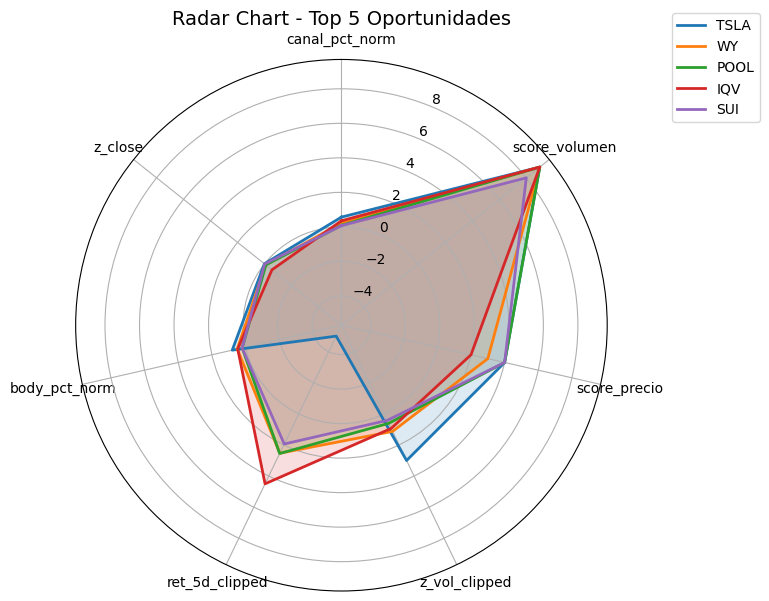

In [13]:
import matplotlib.pyplot as plt
from math import pi
from sklearn.preprocessing import MinMaxScaler

# === Seleccionar top 5 por score_final ===
top5 = df_filtrados.sort_values("score_final", ascending=False).head(5).copy()

# === Métricas a incluir en el radar chart ===
metrics = [
    "canal_pct_norm", "score_volumen", "score_precio",
    "z_vol_clipped", "ret_5d_clipped", "body_pct_norm", "z_close"
]

# === Preparar DataFrame para el gráfico ===
radar_df = top5.set_index("simbolo")[metrics]

# === Configurar ángulos y estructura ===
num_vars = len(metrics)
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # cerrar el polígono

# === Crear gráfico ===
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for name, row in radar_df.iterrows():
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, label=name, linewidth=2)
    ax.fill(angles, values, alpha=0.15)

# === Personalización ===
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids([a * 180 / pi for a in angles[:-1]], metrics)
ax.set_title("Radar Chart - Top 5 Oportunidades", size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()


In [7]:
from datetime import datetime
import os
import pandas as pd

# Obtener top 10 ordenado
top10_export = df_filtrados.sort_values("score_final", ascending=False).head(10).copy()

# Agregar columna de fecha de señal
top10_export["fecha_senal"] = pd.Timestamp.today().normalize()

# Ruta local de salida
fecha_hoy = datetime.now().strftime("%Y-%m-%d")
output_path = f"D:/trading/reports/senales_heuristicas/exploracion/top10_oportunidades_{fecha_hoy}.csv"

# Asegurar que exista el directorio
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Exportar a CSV
top10_export.to_csv(output_path, index=False)
print(f"Archivo guardado en: {output_path}")



Archivo guardado en: D:/trading/reports/senales_heuristicas/exploracion/top10_oportunidades_2025-06-06.csv
